# Modelo econométrico  para previsão dos gastos da previdência social 
 Utilizando o método SARIMA e Holt Winters

## 1- Tratando os dados

In [78]:
# Importando as principais bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_arch


In [79]:
# Criando o DF
df= pd.read_csv('dados_entrada/valor_despesa_inss.csv', sep=';', encoding='latin1',header=1)
df_atd = pd.read_csv('dados_entrada/atendimento.csv', sep=';', encoding='latin1', header=0)
df_atd.columns = ['Ano', 'Atendimentos']

# Drop total
df.drop('Total',axis=1,inplace=True)

In [80]:
df_atd = df_atd[df_atd['Ano'] != 'Total']

In [81]:
# Substituir vírgulas por pontos para converter strings para floats
df.iloc[:, 1:] = df.iloc[:, 1:].replace(',', '.', regex=True).astype(float)

# Transformar o DataFrame no formato longo (melt)
df_long = df.melt(id_vars=['Ano'], var_name='Mês', value_name='Valor')

# Mapeamento dos meses para formato numérico
month_mapping = {
    'Janeiro': '01',
    'Fevereiro': '02',
    'Março': '03',
    'Abril': '04',
    'Maio': '05',
    'Junho': '06',
    'Julho': '07',
    'Agosto': '08',
    'Setembro': '09',
    'Outubro': '10',
    'Novembro': '11',
    'Dezembro': '12'
}

# Mapear os meses e remover linhas inválidas
df_long['Mês'] = df_long['Mês'].map(month_mapping)
df_long = df_long[df_long['Mês'].notna()]

# Criar a coluna 'Data' no formato MM/YYYY
df_long['Data'] = pd.to_datetime(df_long['Ano'].astype(str) + '/' + df_long['Mês'], format='%Y/%m', errors='coerce')

# Remover linhas inválidas onde 'Data' é NaT
df_long = df_long[df_long['Data'].notna()]

# Selecionar as colunas finais
df_final = df_long[['Data', 'Valor']]

In [82]:
# Organizar o DataFrame pela coluna 'Data' em ordem crescente
df_final = df_final.sort_values(by='Data')

# Resetar os índices para manter o DataFrame limpo (opcional)
df_final = df_final.reset_index(drop=True)

In [83]:
df = df_final

# Data vira index
df.set_index('Data', inplace=True)
# Somente valor depois de data 1999-12-01
df = df[df.index >= '2000-01-01']

# Converter a coluna 'Valor' para float
df['Valor'] = df['Valor'].astype(float)

# Arredondar para milhao e duas casas decimais
df['Valor'] = df['Valor'] / 1000000
df['Valor'] = df['Valor'].round(2)

df3 = df.copy()
df5 = df.copy()
df6 = df.copy()
df_sarima = df.copy()
df_fb = df.copy()

In [84]:
df_sarima.to_excel('dados_saida/df_sarima.xlsx')

In [85]:
# Ler o arquivo ajustando o cabeçalho para a segunda linha
df_grupo = pd.read_csv('dados_entrada/ativos_grupos.csv', sep=';', encoding='latin1', header=1)

# Manter apenas as primeiras 21 linhas do DataFrame
df_grupo = df_grupo.iloc[:21]

In [86]:
# Corrigir possíveis caracteres especiais nos nomes das colunas
df_grupo.columns = df_grupo.columns.str.replace('\xa0', ' ', regex=True)

# Converter todas as colunas para números inteiros
df_grupo = df_grupo.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

# Combinar as colunas especificadas em uma única coluna chamada 'Aposentadorias'
colunas_para_somar = [
    '42-Ap Tempo Contrib LOPS', '46-Ap Tempo Contrib Especial',
       'Outras Ap Tempo Contrib', 'Ap Idade', 'Ap Idade Rural', 'Ap Invalidez',
       'Ap Invalidez Rural','Aposentadoria por Invalidez Acidentária','EPU - Ap. Invalidez'
]
df_grupo['Aposentadorias'] = df_grupo[colunas_para_somar].sum(axis=1)

# Remover as colunas antigas
df_grupo = df_grupo.drop(columns=colunas_para_somar)

In [87]:
# Combinar as colunas especificadas em uma única coluna chamada 'Aposentadorias'
colunas_para_somar = [
    'Auxílio Doença',
    'Auxílio Doença Acidentário',
]
df_grupo['Auxílio Doença'] = df_grupo[colunas_para_somar].sum(axis=1)

# Remover as colunas antigas
df_grupo = df_grupo.drop(columns='Auxílio Doença Acidentário')

In [88]:
# Combinar as colunas especificadas em uma única coluna chamada 'Aposentadorias'
colunas_para_somar = [
    'Auxílio Acidente',
    'Auxílio Acidente Acidentário',
]
df_grupo['Auxílio Acidente'] = df_grupo[colunas_para_somar].sum(axis=1)

# Remover as colunas antigas
df_grupo = df_grupo.drop(columns='Auxílio Acidente Acidentário')

In [89]:
lista_drop = ['Abono de Permanência','Vantagem do Servidor','EPU - Ap. TC Anistiados', 'EPU - Pensão por Morte',
       'EPU - Pensões Mensais Vitalícias','Pensões Mensais Vitalícias - Seringueiro','Pensões Mensais Vitalícias - Dep. Seringueiro' ]
df_grupo = df_grupo.drop(columns= lista_drop)

In [90]:
# Taxa de crescimento de todos menos o ANO
crescimento = (df_grupo['Total'].iloc[-1] - df_grupo['Total'].iloc[0]) / df_grupo['Total'].iloc[0] * 100
crescimento

np.float64(81.14916820166201)

In [91]:
# Ler o arquivo ajustando o cabeçalho para a segunda linha
df_valor = pd.read_csv('dados_entrada/ativos_valor.csv', sep=';', encoding='latin1', header=1)
# Substituir vírgulas por pontos e converter para float, exceto a primeira coluna (Ano)

# Manter apenas as primeiras 21 linhas do DataFrame
df_valor = df_valor.iloc[:21]

for coluna in df_valor.columns[1:]:  # Pular a primeira coluna (Ano)
    df_valor[coluna] = df_valor[coluna].str.replace(',', '.').astype(float)

# Converter a coluna 'Ano' para int
df_valor['Ano'] = df_valor['Ano'].astype(int)

In [92]:
# Corrigir possíveis caracteres especiais nos nomes das colunas
df_valor.columns = df_valor.columns.str.replace('\xa0', ' ', regex=True)


# Combinar as colunas especificadas em uma única coluna chamada 'Aposentadorias'
colunas_para_somar = [ '42-Ap Tempo Contrib LOPS', '46-Ap Tempo Contrib Especial',
       'Outras Ap Tempo Contrib', 'Ap Idade', 'Ap Idade Rural', 'Ap Invalidez',
       'Ap Invalidez Rural','Aposentadoria por Invalidez Acidentária', 'EPU - Ap. Invalidez']

df_valor['Aposentadorias'] = df_valor[colunas_para_somar].sum(axis=1)

# Remover as colunas antigas
df_valor= df_valor.drop(columns=colunas_para_somar)

In [93]:
# Combinar as colunas especificadas em uma única coluna chamada 'Aposentadorias'
colunas_para_somar = [
    'Auxílio Doença',
    'Auxílio Doença Acidentário',
]
df_valor['Auxílio Doença'] = df_valor[colunas_para_somar].sum(axis=1)

# Remover as colunas antigas
df_valor = df_valor.drop(columns='Auxílio Doença Acidentário')

In [94]:
# Combinar as colunas especificadas em uma única coluna chamada 'Aposentadorias'
colunas_para_somar = [
    'Auxílio Acidente',
    'Auxílio Acidente Acidentário',
]
df_valor['Auxílio Acidente'] = df_valor[colunas_para_somar].sum(axis=1)

# Remover as colunas antigas
df_valor = df_valor.drop(columns='Auxílio Acidente Acidentário')

In [95]:
lista_drop = ['Abono de Permanência','Vantagem do Servidor','EPU - Ap. TC Anistiados', 'EPU - Pensão por Morte',
       'EPU - Pensões Mensais Vitalícias','Pensões Mensais Vitalícias - Seringueiro','Pensões Mensais Vitalícias - Dep. Seringueiro' ]
df_valor = df_valor.drop(columns= lista_drop)

In [96]:
# Lista de cores exclusivas definidas manualmente para cada benefício
cores = [
    '#1f77b4',  # Pensões por Morte
    '#ff7f0e',  # Auxílio Doença
    '#2ca02c',  # Auxílio Reclusão
    '#d62728',  # Auxílio Acidente
    '#9467bd',  # Salário-Família
    '#8c564b',  # 80-Salário-Maternidade
    '#e377c2',  # Auxílio Suplementar Acidentário
    '#7f7f7f',  # Pensão por Morte Acidentária
    '#bcbd22',  # Rmv Invalidez
    '#17becf',  # Rmv Idade
    '#a55194',  # 87-Amparo Portador de Deficiência
    '#63cdda',  # 88-Amparo Idoso
    '#ff1493',  # EPU - Salário-Família
    '#228b22'   # Aposentadorias
]

# Definir a lista de benefícios
beneficios = [
   'Pensões por Morte', 'Auxílio Doença', 'Auxílio Reclusão',
       'Auxílio Acidente', 'Salário-Família', '80-Salário-Maternidade',
       'Auxílio Suplementar Acidentário', 'Pensão por Morte Acidentária',
       'Rmv Invalidez', 'Rmv Idade', '87-Amparo Portador de Deficiência',
       '88-Amparo Idoso', 'EPU - Salário-Família',  'Aposentadorias'
]


In [97]:
# DF com total de grupo e valor
df_total = pd.DataFrame()
# Criando coluna ano de 2000 ate 2022
df_total['Ano'] = df_grupo['Ano']
df_total['Quantidade de Benefícios'] = df_grupo['Total']
df_total['Gastos com Benefícios'] = df_valor['Total']

In [98]:
# dividindo tudo por milhao e arredondando pra uma casa decimal
df_total['Quantidade de Benefícios'] = df_total['Quantidade de Benefícios'] / 1_000_000
df_total['Quantidade de Benefícios'] = df_total['Quantidade de Benefícios'].round(1)
df_total['Gastos com Benefícios'] = df_total['Gastos com Benefícios'] / 1_000_000_000
df_total['Gastos com Benefícios'] = df_total['Gastos com Benefícios'].round(1)


## 2- Análise de dados

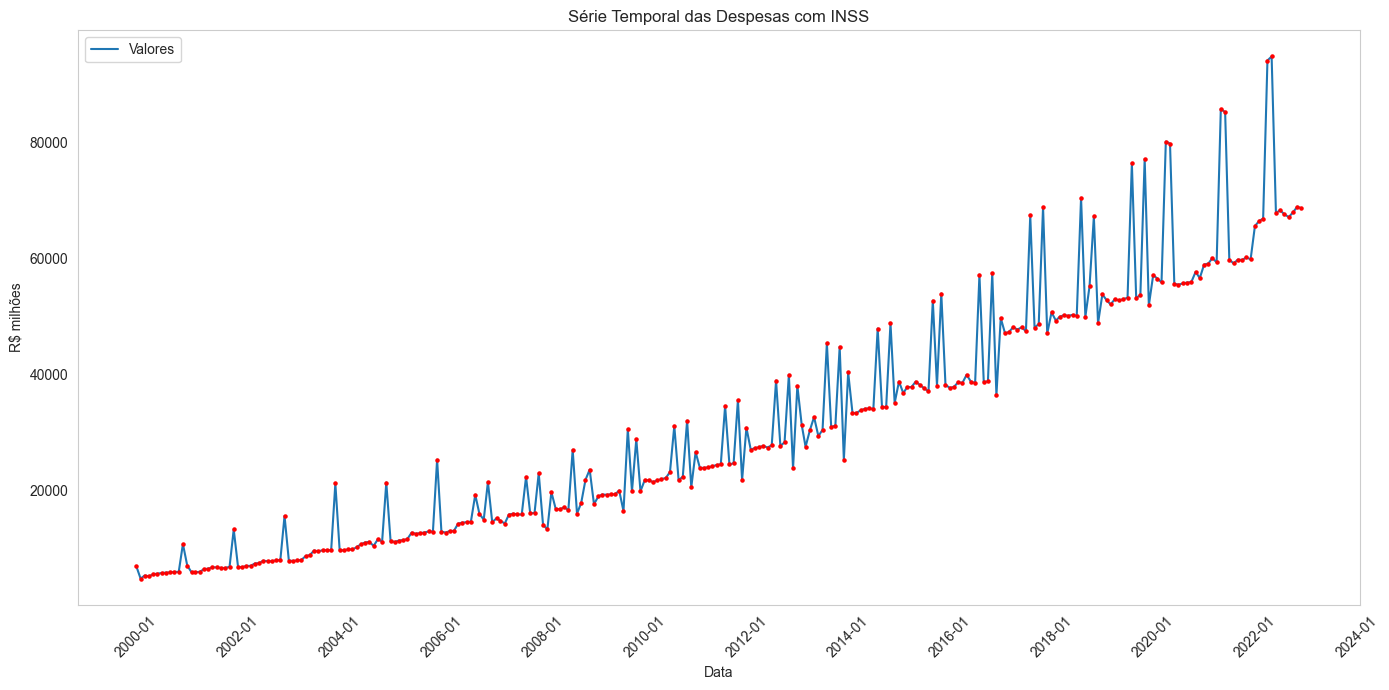

In [99]:
plt.figure(figsize=(14, 7))
sns.lineplot(x=df.index, y=df['Valor'], label='Valores')
plt.scatter(df.index, df['Valor'], color='red', s=5, zorder=5)

# Configurando o formato e os ticks do eixo X
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Intervalo de 2 anos
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xticks(rotation=45)

# Configurações adicionais
plt.title('Série Temporal das Despesas com INSS')
plt.xlabel('Data')
plt.ylabel('R$ milhões')
plt.tight_layout()
plt.grid(False)
plt.show()


In [100]:
import plotly.express as px
# Criar o gráfico de série temporal interativo
fig = px.line(
    df_final,
    x=df_final.index,
    y='Valor',
    title='Série Temporal dos Gastos com INSS',
    labels={'x': 'Data', 'Valor': 'R$ milhões'},
)

# Ajustar layout para melhor visualização
fig.update_layout(
    xaxis_title='Data',
    yaxis_title='R$ milhões',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=True),
    template='plotly_white'
)

# Exibir o gráfico interativo
fig.show()

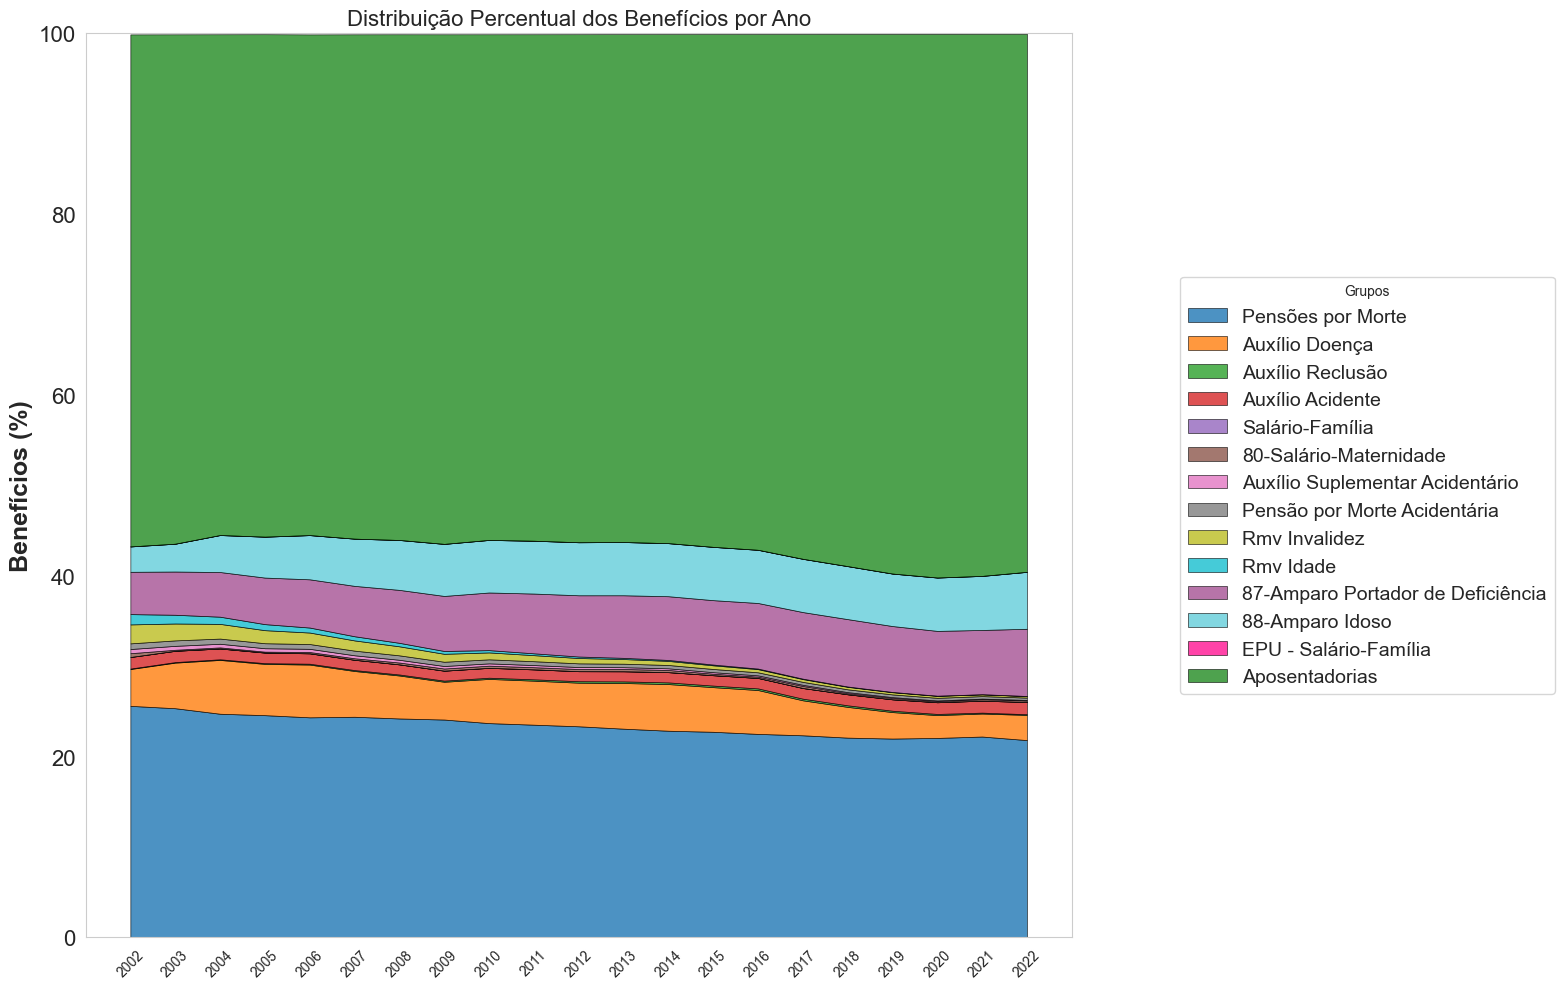

In [101]:
# Calcular a distribuição percentual dos benefícios
df_percentual = df_grupo.copy()
for beneficio in beneficios:
    df_percentual[beneficio] = (df_grupo[beneficio] / df_grupo['Total']) * 100

# Preparar os dados para o gráfico de área empilhada
anos = df_grupo["Ano"]
valores = [df_percentual[beneficio] for beneficio in beneficios]

# Criar o gráfico de áreas empilhadas
fig, ax = plt.subplots(figsize=(16, 10))

# Adicionar áreas empilhadas com bordas pretas
ax.stackplot(anos, valores, labels=beneficios, colors=cores, alpha=0.8, edgecolor='black', linewidth=0.5)

# Configurar o eixo principal
ax.set_ylabel("Benefícios (%)", fontsize=18, fontweight='bold')
ax.set_title("Distribuição Percentual dos Benefícios por Ano", fontsize=16)
ax.legend(title="Grupos", bbox_to_anchor=(1.10, 0.5), loc="center left", fontsize=14)
ax.set_xticks(anos)
ax.tick_params(axis='y', labelsize=16)  # Aumentar os valores do eixo Y
plt.xticks(rotation=45)
plt.ylim(0, 100)  # Ajusta a escala para 100%
plt.tight_layout()
plt.grid(False)

# Exibir o gráfico
plt.show()

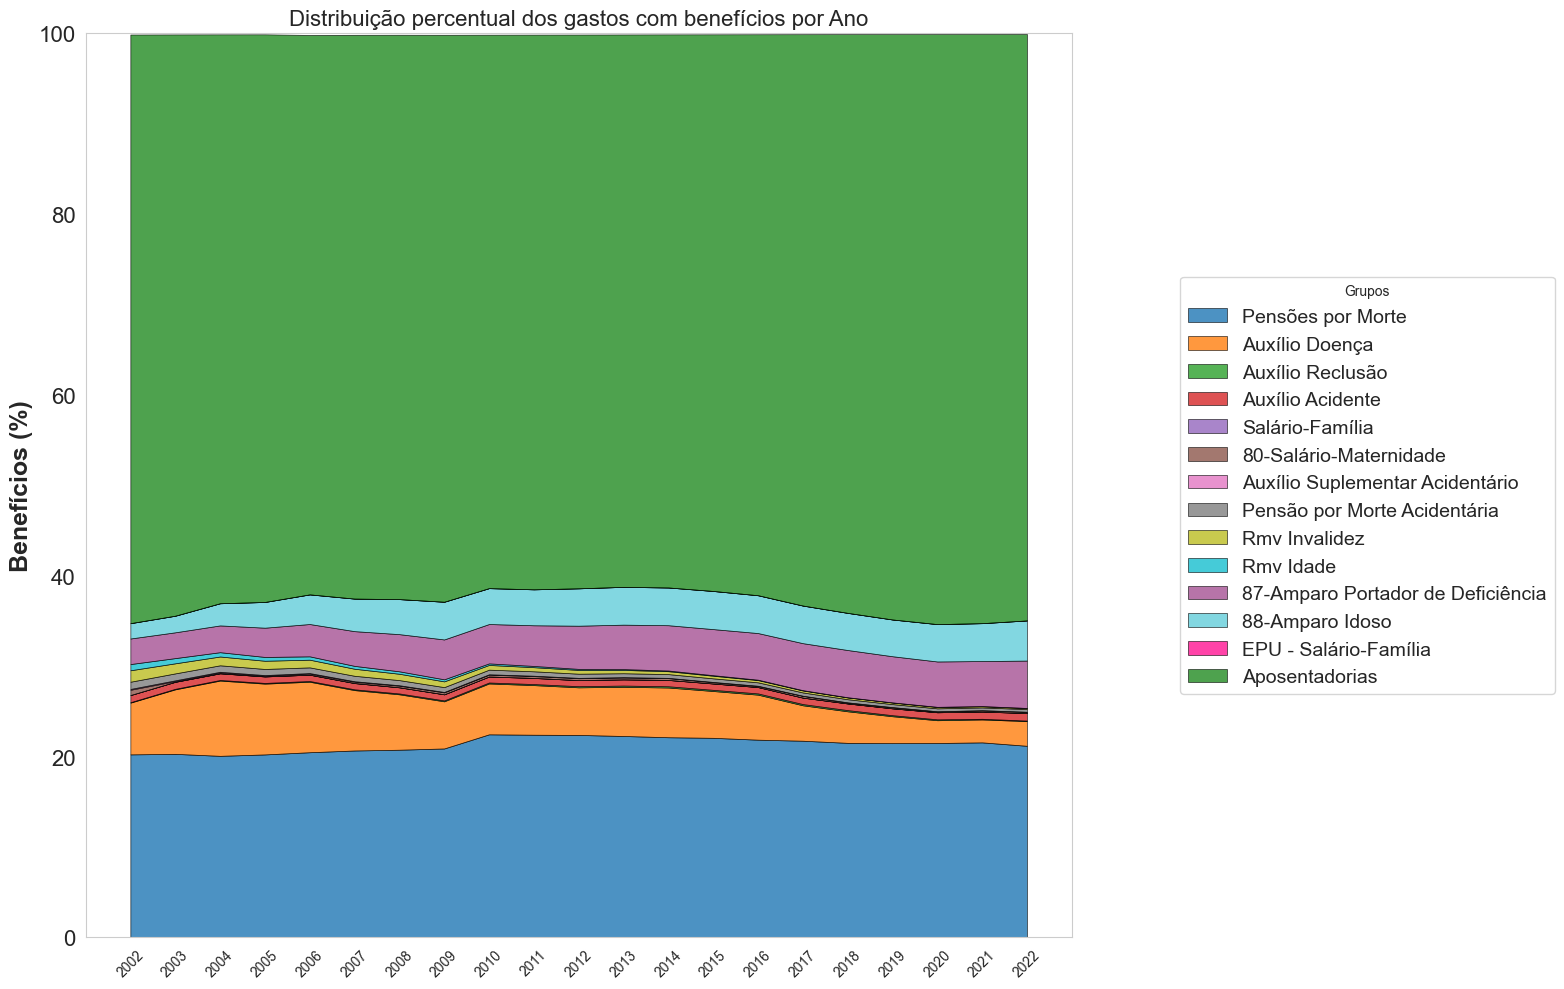

In [102]:
# Calcular a distribuição percentual dos benefícios
df_percentual = df_valor.copy()
for beneficio in beneficios:
    df_percentual[beneficio] = (df_valor[beneficio] / df_valor['Total']) * 100

# Preparar os dados para o gráfico de área empilhada
anos = df_valor["Ano"]
valores = [df_percentual[beneficio] for beneficio in beneficios]

# Criar o gráfico de áreas empilhadas
fig, ax = plt.subplots(figsize=(16, 10))

# Adicionar áreas empilhadas com bordas pretas
ax.stackplot(anos, valores, labels=beneficios, colors=cores, alpha=0.8, edgecolor='black', linewidth=0.5)

# Configurar o eixo principal
ax.set_ylabel("Benefícios (%)", fontsize=18, fontweight='bold')
ax.set_title("Distribuição percentual dos gastos com benefícios por Ano", fontsize=16)
ax.legend(title="Grupos", bbox_to_anchor=(1.10, 0.5), loc="center left", fontsize=14)
ax.set_xticks(anos)
ax.tick_params(axis='y', labelsize=16)  # Aumentar os valores do eixo Y
plt.xticks(rotation=45)
plt.ylim(0, 100)  # Ajusta a escala para 100%
plt.tight_layout()
plt.grid(False)

# Exibir o gráfico
plt.show()

In [103]:
# Valor médio dos benefícios 
# Mantendo a primeira coluna e dividindo as demais
result = df_valor.copy()
result.iloc[:, 1:] = df_valor.iloc[:, 1:] / df_grupo.iloc[:, 1:]

# Exibindo o resultado
# PRECISA DE PONDERAR
result

,Ano,Pensões por Morte,Auxílio Doença,Auxílio Reclusão,Auxílio Acidente,Salário-Família,80-Salário-Maternidade,Auxílio Suplementar Acidentário,Pensão por Morte Acidentária,Rmv Invalidez,Rmv Idade,87-Amparo Portador de Deficiência,88-Amparo Idoso,EPU - Salário-Família,Total,Aposentadorias
0,2002,261.744202,465.007417,331.639963,204.044433,0.000,458.794900,66.757386,422.016784,200.000013,200.000000,200.000206,200.000000,NaN,331.122282,380.671576
1,2003,322.216772,569.329428,397.971718,250.018557,0.000,272.764789,79.909229,510.544115,240.000015,240.000000,240.000233,240.000000,NaN,402.317305,459.097747
2,2004,352.237020,606.733869,414.068901,268.504539,0.140,321.083591,83.648491,541.619783,259.999993,260.000000,260.000232,260.000000,NaN,433.864738,492.867857
3,2005,392.918292,659.122147,437.158182,293.400665,0.135,366.363650,89.204151,582.604789,300.000366,300.000000,300.000199,299.999906,NaN,477.192599,539.066493
4,2006,439.510457,698.004355,455.091583,316.485549,NaN,417.528070,93.862270,618.844534,350.000364,350.000000,350.001668,350.000830,0.135000,522.315193,583.593634
5,2007,467.057276,727.328656,471.843252,335.191841,NaN,469.917025,97.076435,645.074916,380.000379,380.000000,380.014845,380.004655,0.136667,551.287138,616.256668
6,2008,506.780628,762.427676,495.652713,359.970375,NaN,507.354309,101.641941,683.398360,415.000402,415.000000,415.012049,415.003975,0.135714,591.158970,659.715213
7,2009,556.784649,800.871414,531.747414,391.588470,NaN,572.148557,107.503443,730.025117,464.999922,465.000000,465.013396,465.003787,0.136667,641.946180,714.183425
8,2010,707.774511,859.527006,596.230446,453.410255,NaN,622.490153,138.001093,853.584535,509.999731,510.000000,509.995149,509.998174,0.136667,746.855746,817.396902
9,2011,763.166358,902.852070,632.179251,491.313970,NaN,676.982168,147.506659,915.603143,544.998525,544.998808,544.993068,544.998609,0.134000,800.945852,877.160900


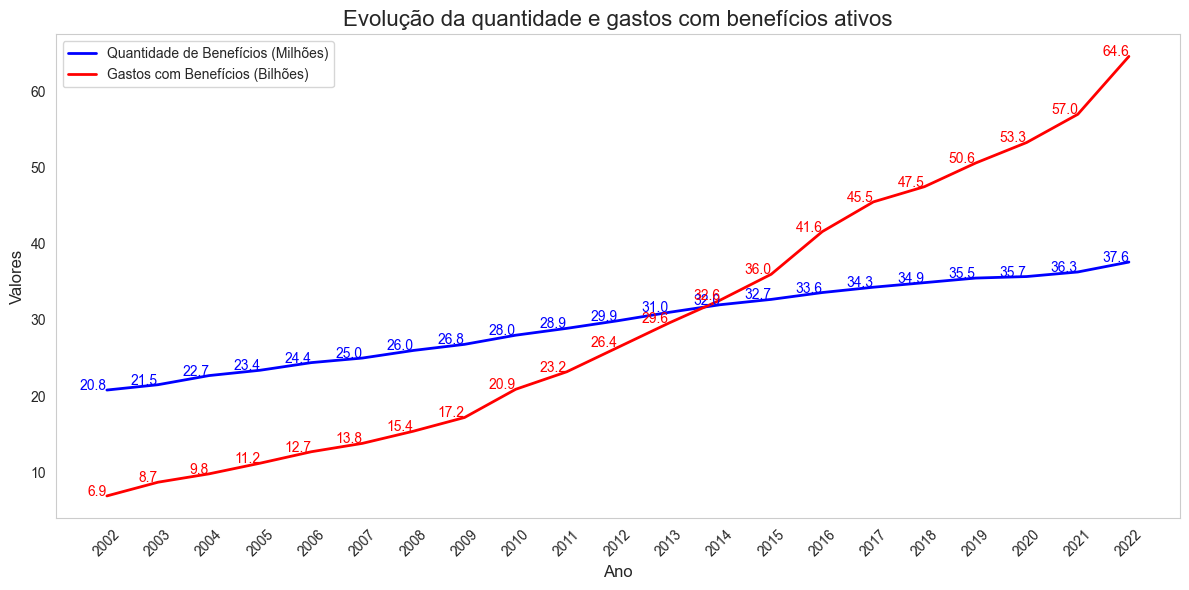

In [104]:
# Criando uma cópia do dataframe para transformação
df_normalizado = df_total.copy()

# Normalizando os valores em relação à primeira linha
df_normalizado.iloc[:, 1:] = df_total.iloc[:, 1:].div(df_total.iloc[0, 1:])

# Configurar o estilo do Seaborn
sns.set_style("whitegrid")

# Criar o gráfico de linha
plt.figure(figsize=(12, 6))
plt.plot(df_total['Ano'], df_total['Quantidade de Benefícios'], label='Quantidade de Benefícios (Milhões)', color='blue', linewidth=2)
plt.plot(df_total['Ano'], df_total['Gastos com Benefícios'], label='Gastos com Benefícios (Bilhões)', color='red', linewidth=2)

# Adicionar os valores como anotação no gráfico
for x, y in zip(df_total['Ano'], df_total['Quantidade de Benefícios']):
    plt.text(x, y, f'{y:,}', fontsize=10, ha='right', color='blue')  # Anotação para Quantidade de Benefícios

for x, y in zip(df_total['Ano'], df_total['Gastos com Benefícios']):
    plt.text(x, y, f'{y:,}', fontsize=10, ha='right', color='red')  # Anotação para Gastos com Benefícios

# Adicionar título e rótulos
plt.title("Evolução da quantidade e gastos com benefícios ativos", fontsize=16)
plt.xlabel("Ano", fontsize=12)
plt.ylabel("Valores", fontsize=12)

# Configurar os valores no eixo X
plt.xticks(df_total['Ano'], rotation=45)
plt.legend()

# Ajustar o layout e exibir
plt.tight_layout()
plt.grid(False)
plt.show()

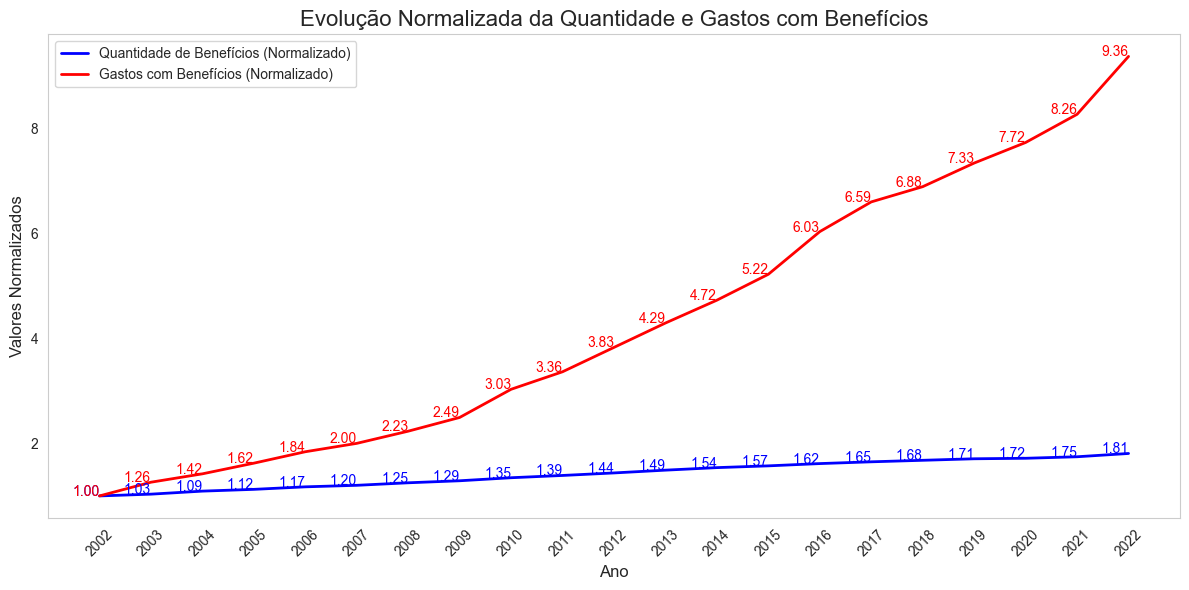

In [105]:
# Criando uma cópia do dataframe para transformação
df_normalizado = df_total.copy()

# Normalizando os valores em relação à primeira linha
df_normalizado.iloc[:, 1:] = df_total.iloc[:, 1:].div(df_total.iloc[0, 1:])

# Configurar o estilo do Seaborn
sns.set_style("whitegrid")

# Criar o gráfico de linha
plt.figure(figsize=(12, 6))
plt.plot(df_normalizado['Ano'], df_normalizado['Quantidade de Benefícios'], label='Quantidade de Benefícios (Normalizado)', color='blue', linewidth=2)
plt.plot(df_normalizado['Ano'], df_normalizado['Gastos com Benefícios'], label='Gastos com Benefícios (Normalizado)', color='red', linewidth=2)

# Adicionar os valores como anotação no gráfico
for x, y in zip(df_normalizado['Ano'], df_normalizado['Quantidade de Benefícios']):
    plt.text(x, y, f'{y:.2f}', fontsize=10, ha='right', color='blue')  # Anotação para Quantidade de Benefícios

for x, y in zip(df_normalizado['Ano'], df_normalizado['Gastos com Benefícios']):
    plt.text(x, y, f'{y:.2f}', fontsize=10, ha='right', color='red')  # Anotação para Gastos com Benefícios

# Adicionar título e rótulos
plt.title("Evolução Normalizada da Quantidade e Gastos com Benefícios", fontsize=16)
plt.xlabel("Ano", fontsize=12)
plt.ylabel("Valores Normalizados", fontsize=12)

# Configurar os valores no eixo X
plt.xticks(df_normalizado['Ano'], rotation=45)
plt.legend()

# Ajustar o layout e exibir
plt.tight_layout()
plt.grid(False)
plt.show()


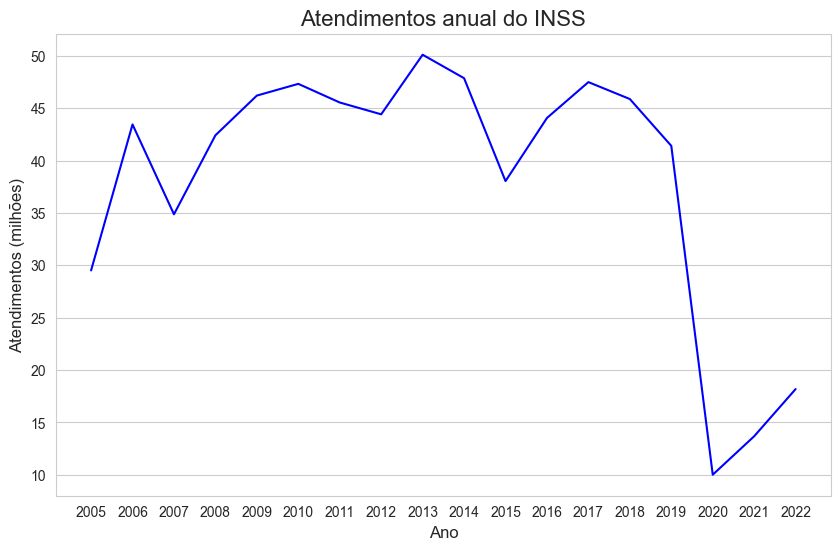

In [106]:
# Criar o gráfico de linha

df_atd['Atendimentos'] = df_atd['Atendimentos'] / 1_000_000
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_atd, x='Ano', y='Atendimentos', color='blue')

# Configurar o gráfico
plt.title('Atendimentos anual do INSS', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Atendimentos (milhões)', fontsize=12)

# Somente grade horizontal
plt.grid(axis='x')

# Mostrar o gráfico
plt.show()

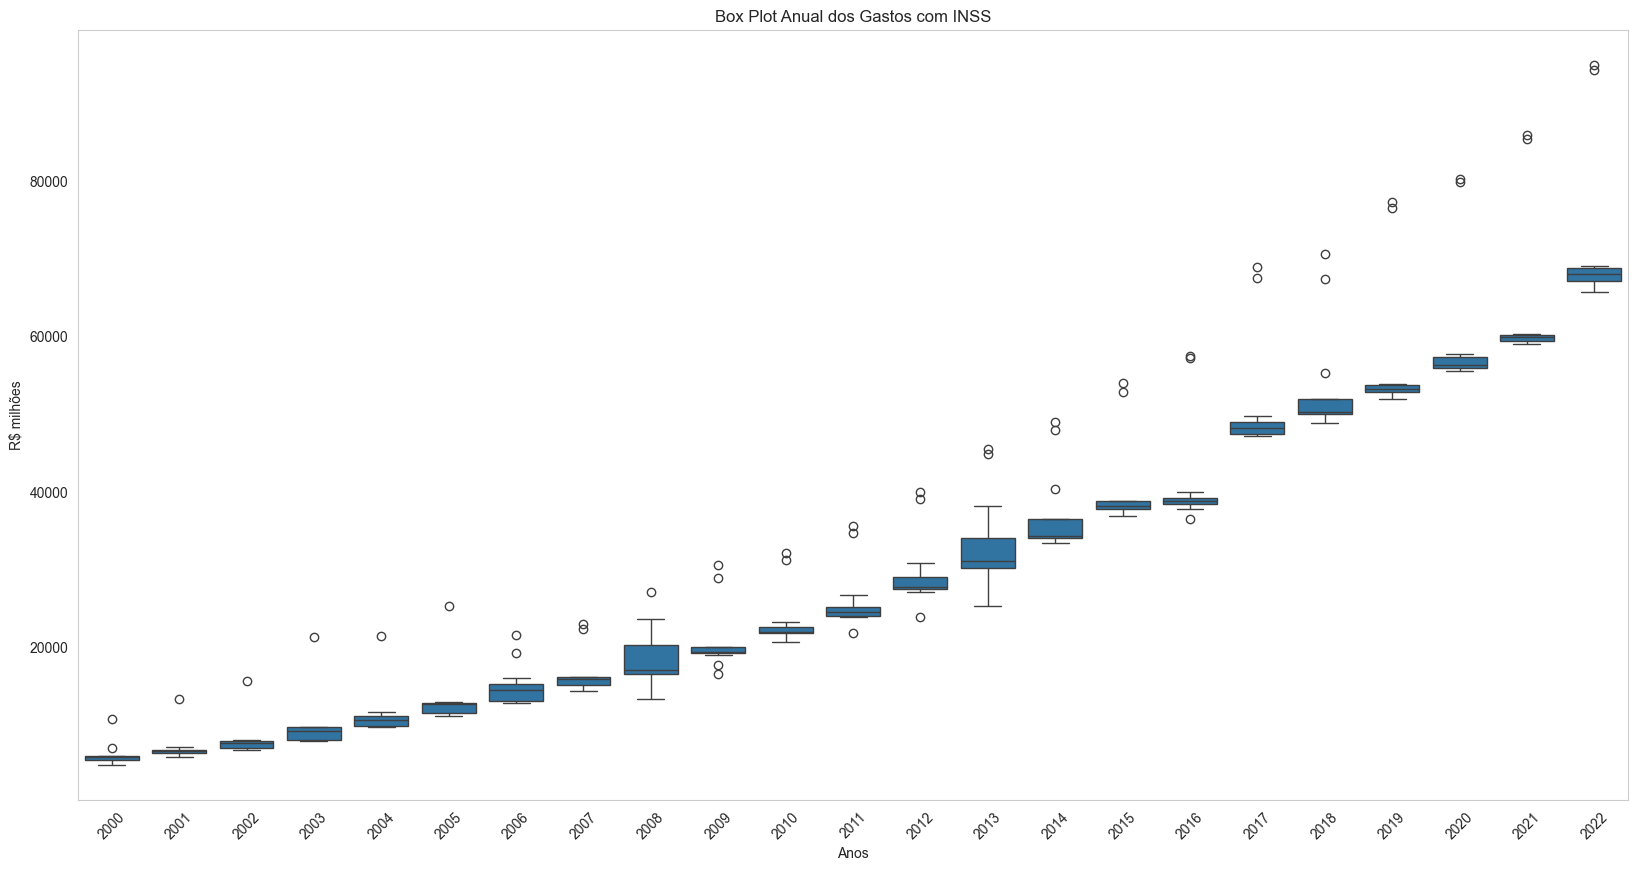

In [107]:
# Criando gráfico Box Plot anual
df['Ano'] = df.index.year


plt.figure(figsize=(20, 10))
sns.boxplot(x='Ano', y='Valor', data=df)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.title('Box Plot Anual dos Gastos com INSS')
plt.xlabel('Anos')
plt.ylabel('R$ milhões')
plt.grid(False)
plt.xticks(rotation=45)
plt.show()

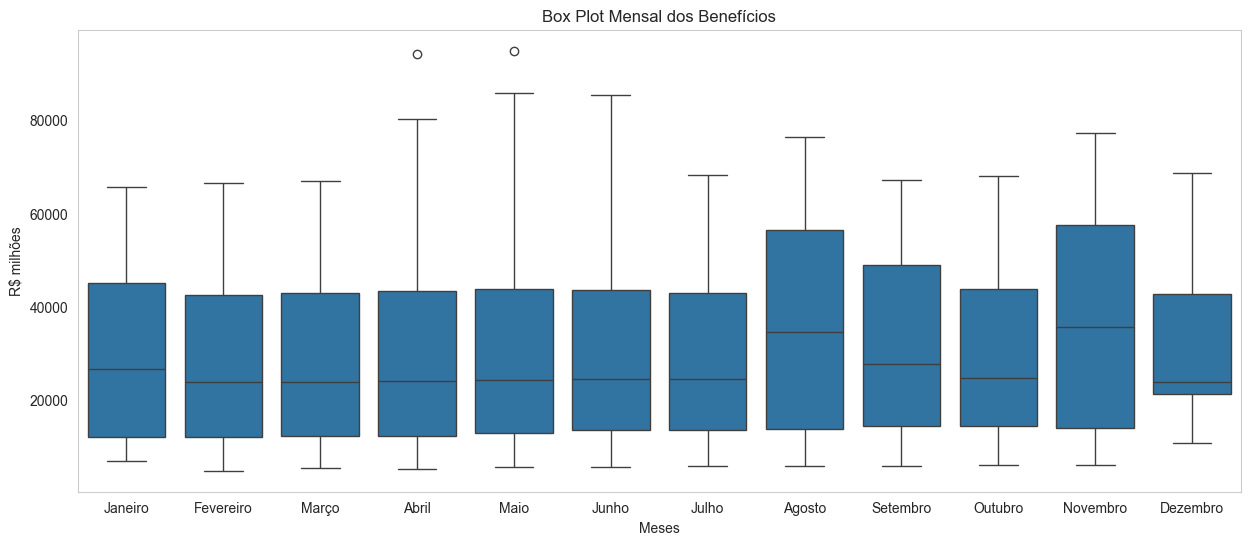

In [108]:
# Analisando efeito sazonal por meio do Box Plot
meses = {1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
         7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'}

df['Mês'] = df.index.month.map(meses)


plt.figure(figsize=(15, 6))
sns.boxplot(x='Mês', y='Valor', data=df)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.title('Box Plot Mensal dos Benefícios')
plt.xlabel('Meses')
plt.ylabel('R$ milhões')
plt.grid(False)
plt.show()

In [109]:
# Decompondo a série para novas análises
serie_temporal = df['Valor']
decomposicao = sm.tsa.seasonal_decompose(serie_temporal, model='additive')

<Figure size 2000x1000 with 0 Axes>

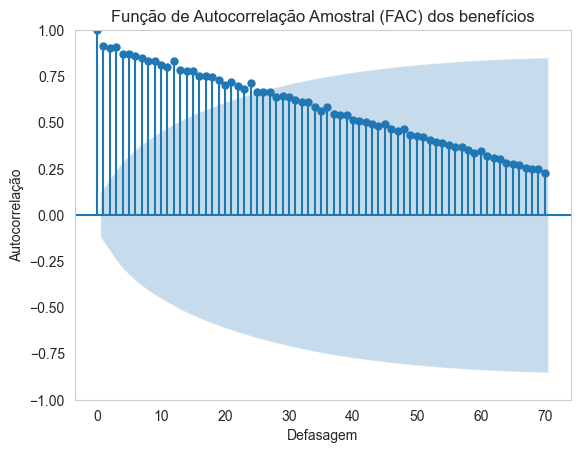

In [110]:
# Criando gráfico de FAC
plt.figure(figsize=(20, 10))
plot_acf(serie_temporal, lags=70)
plt.title('Função de Autocorrelação Amostral (FAC) dos benefícios')
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação')
plt.grid(False)
plt.show()

<Figure size 2000x1000 with 0 Axes>

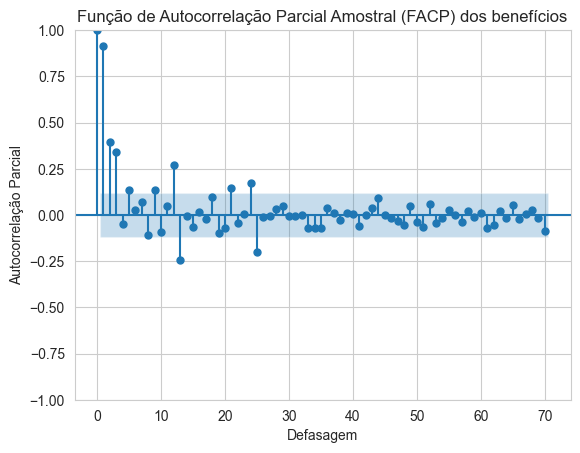

In [111]:
# Criando gráfico FACP
plt.figure(figsize=(20, 10))
plot_pacf(serie_temporal, lags=70)  
plt.title('Função de Autocorrelação Parcial Amostral (FACP) dos benefícios')
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação Parcial')
plt.show()

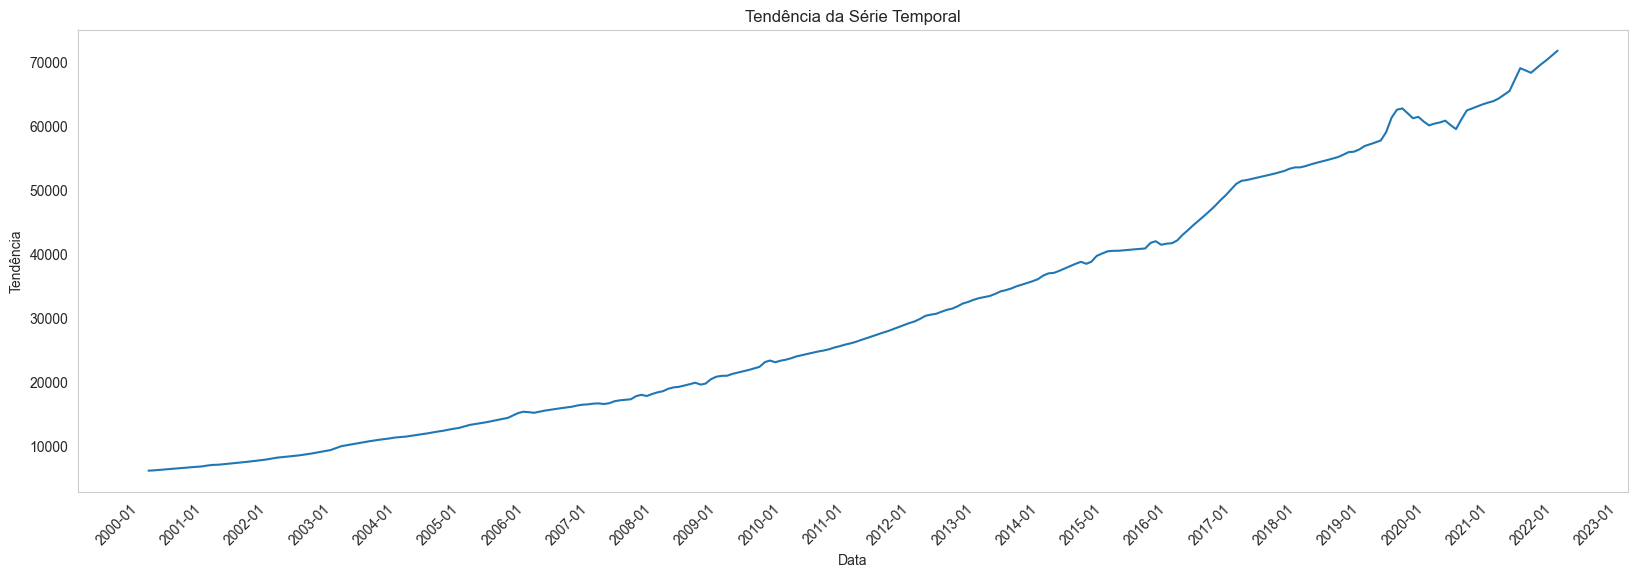

In [112]:
# Gráfico de tendência
plt.figure(figsize=(20, 6))
sns.lineplot(data=decomposicao.trend)
plt.title('Tendência da Série Temporal')
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('Data')
plt.ylabel('Tendência')
plt.grid(False)
plt.xticks(rotation=45)
plt.show()

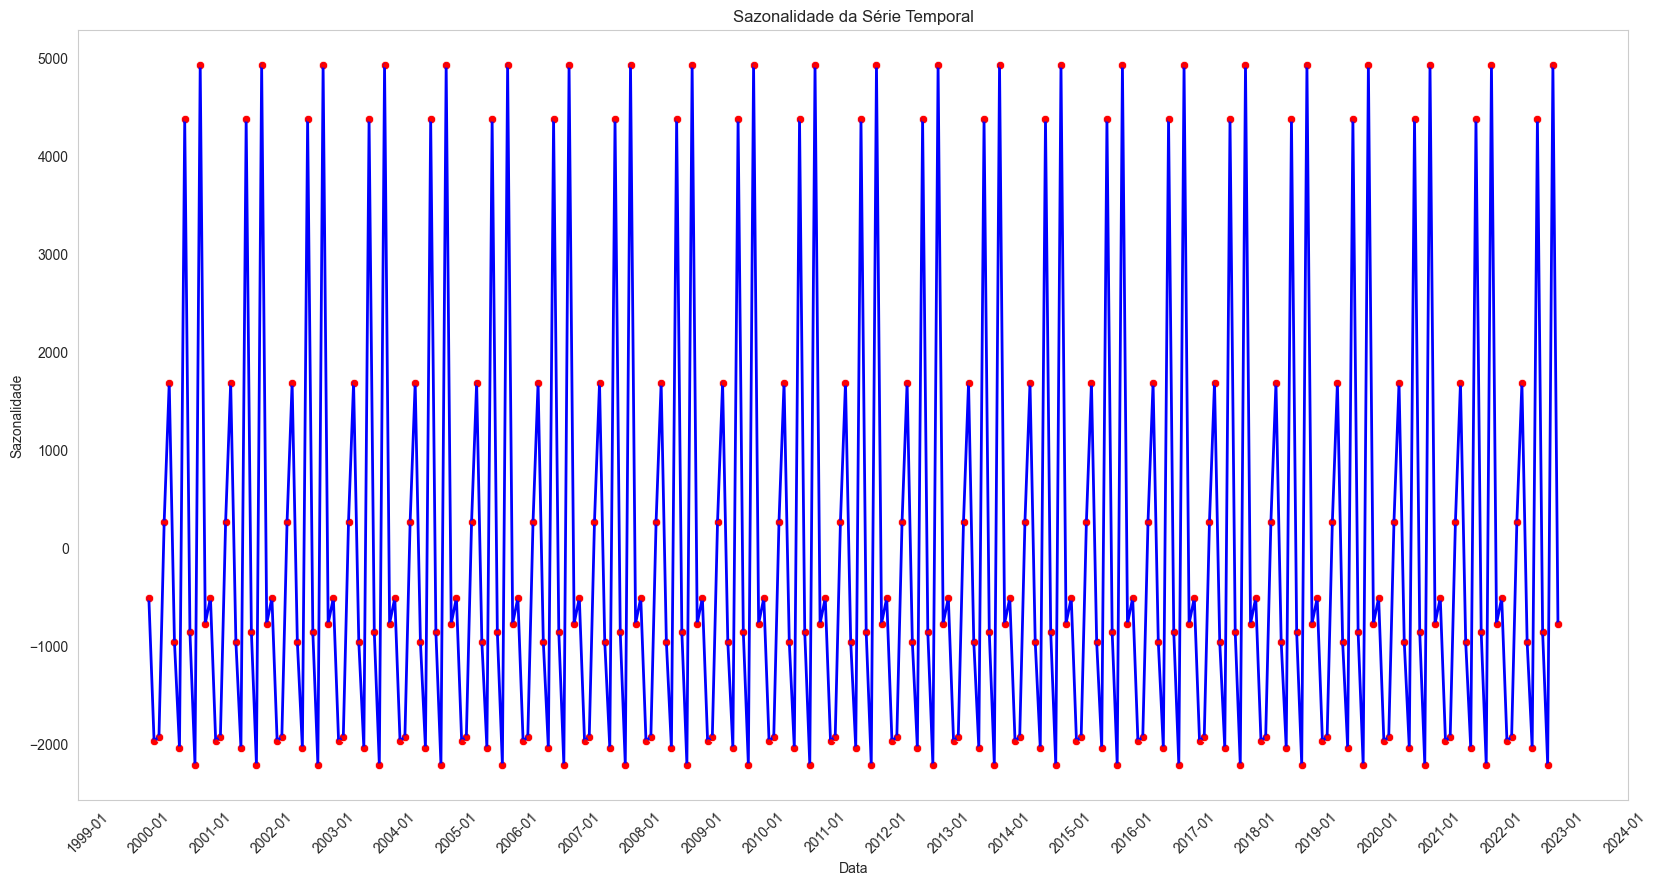

In [113]:
# Gráfico de Sazonalidade
plt.figure(figsize=(20, 10))
sns.lineplot(data=decomposicao.seasonal, color='blue', linewidth=2)
sns.scatterplot(data=decomposicao.seasonal, color='red', marker='o')
plt.scatter(decomposicao.seasonal.index, decomposicao.seasonal.values, color='red', s=5, zorder=5)
plt.title('Sazonalidade da Série Temporal')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('Data')
plt.grid(False)
plt.ylabel('Sazonalidade')
plt.xticks(rotation=45)
plt.show()

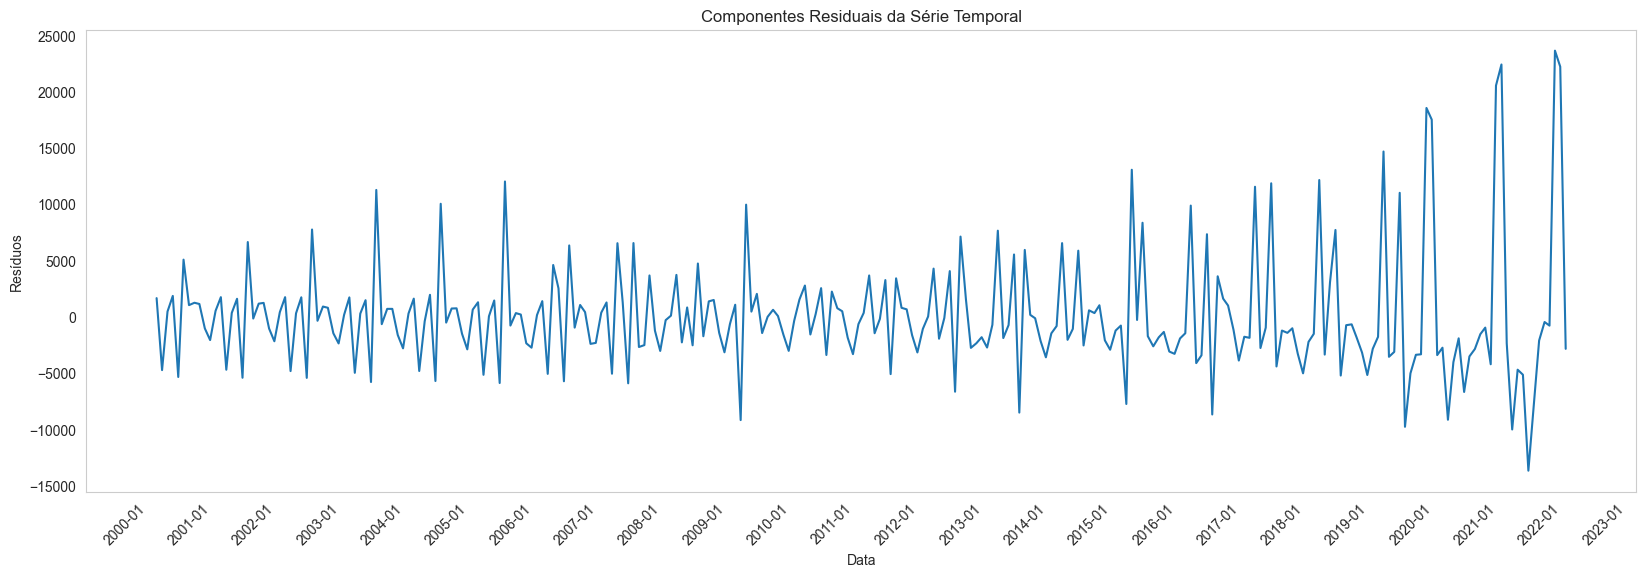

In [114]:
# Gráfico de ruído
plt.figure(figsize=(20,6))
sns.lineplot(data=decomposicao.resid)
plt.title('Componentes Residuais da Série Temporal')
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('Data')
plt.grid(False)
plt.ylabel('Resíduos')
plt.xticks(rotation=45)
plt.show()


In [115]:
# Realizando teste de hipótese de estacionalidade
result= adfuller(df3)
print(f'P-valor {result[1]}')

P-valor 1.0


In [116]:
# Realizando uma diferenciação na série para corrigir a estacionalidade
df3= df3.diff()
df3=df3.dropna()
result2= adfuller(df3)
print(f'P-valor {result2[1]}')

P-valor 9.22710845293677e-27


<Figure size 2000x600 with 0 Axes>

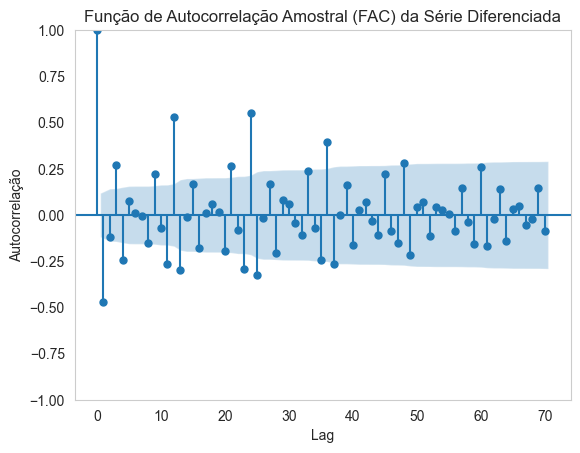

In [117]:
# Novo gráfico FAC
plt.figure(figsize=(20, 6))
plot_acf(df3, lags=70)
plt.title('Função de Autocorrelação Amostral (FAC) da Série Diferenciada')
plt.xlabel('Lag')
plt.ylabel('Autocorrelação')
plt.grid(False)
plt.show()

<Figure size 2000x1000 with 0 Axes>

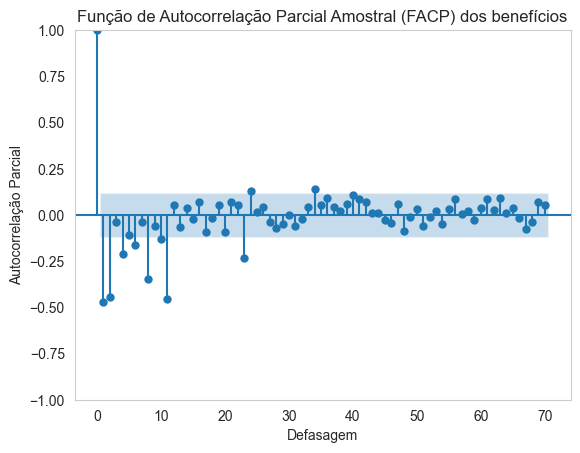

In [118]:
# Novo gráfico FACP
plt.figure(figsize=(20, 10))
plot_pacf(df3, lags=70)  # Define o número de lags para calcular a FACP
plt.title('Função de Autocorrelação Parcial Amostral (FACP) dos benefícios')
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação Parcial')
plt.grid(False)
plt.show()

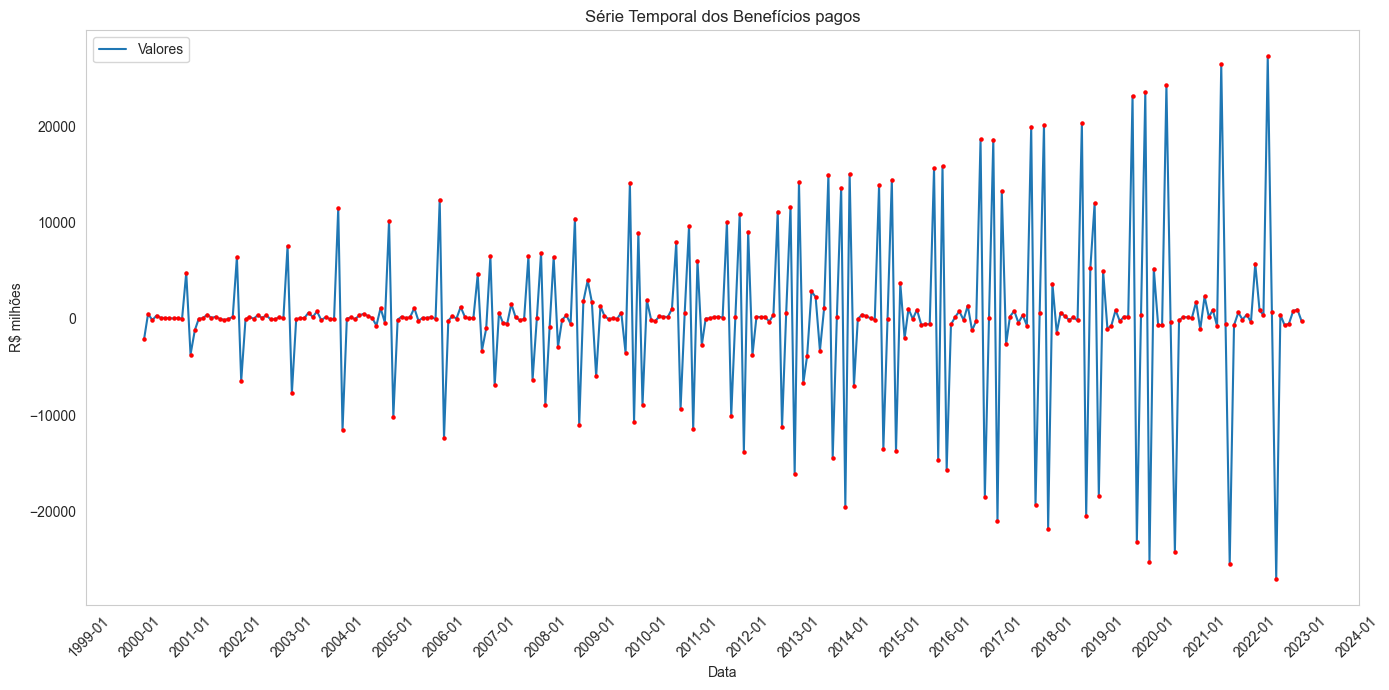

In [119]:
# Novo gráfico de série temporal
plt.figure(figsize=(14, 7))
sns.lineplot(x=df3.index, y=df3['Valor'], label='Valores')
plt.scatter(df3.index, df3['Valor'], color='red', s=5, zorder=5)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xticks(rotation=45)


plt.title('Série Temporal dos Benefícios pagos')
plt.xlabel('Data')
plt.ylabel('R$ milhões')

# Mostrar o gráfico
plt.tight_layout()
plt.grid(False)
plt.show()


## 3- MODELO SARIMA

In [120]:
# Importando bibliotecas para estimar os erros
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [121]:
# Criando uma função para um parâmetro de erro
def mean_percentage_error(Y,y):
    mpe = np.mean((Y - y )/ Y) * 100
    return mpe

In [122]:
# Função para criar DF com valores dos erros
def teste_erro(serie,previsao):

    MAD = mean_absolute_error(y_true=serie,y_pred=previsao)
    MAPE = mean_absolute_percentage_error(y_true=serie,y_pred=previsao)
    MSD = mean_squared_error(y_true=serie,y_pred=previsao)
    MPE = mean_percentage_error(serie,previsao)

    erros = pd.DataFrame({
        'Metric': ['MAD', 'MAPE', 'MSD', 'MPE'],
        'Value': [MAD, MAPE, MSD, MPE]
    })
    
    return erros

In [123]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings


In [ ]:
""" 
import modelo_sarima  # Importa o módulo

# Definir intervalos personalizados
p_values = range(1, 11) 
d_values = [1]  # Manter d fixo
q_values = range(1, 11)  
P_values = range(0, 11)  
D_values = range(0, 2)  
Q_values = range(0, 11)  
s = 12  # Sazonalidade mensal

# Rodar a função com os intervalos escolhidos
modelo_sarima.run_sarima_grid_search(
    file_path="dados_saida/df_sarima.xlsx",
    output_file="resultado/resultados_sarima.xlsx",
    p_values=p_values,
    d_values=d_values,
    q_values=q_values,
    P_values=P_values,
    D_values=D_values,
    Q_values=Q_values,
    s=s
)
"""

Executando modelos SARIMA:   0%|          | 2/24200 [00:00<33:38, 11.99it/s]

Testando modelo 1/24200 - Parâmetros: (p=1, d=1, q=1, P=0, D=0, Q=0)
Testando modelo 2/24200 - Parâmetros: (p=1, d=1, q=1, P=0, D=0, Q=1)
Testando modelo 3/24200 - Parâmetros: (p=1, d=1, q=1, P=0, D=0, Q=2)
Testando modelo 4/24200 - Parâmetros: (p=1, d=1, q=1, P=0, D=0, Q=3)


Executando modelos SARIMA:   0%|          | 4/24200 [00:00<1:50:57,  3.63it/s]

Testando modelo 5/24200 - Parâmetros: (p=1, d=1, q=1, P=0, D=0, Q=4)


Executando modelos SARIMA:   0%|          | 5/24200 [00:02<3:33:15,  1.89it/s]

Testando modelo 6/24200 - Parâmetros: (p=1, d=1, q=1, P=0, D=0, Q=5)


Executando modelos SARIMA:   0%|          | 6/24200 [00:04<6:57:47,  1.04s/it]

Testando modelo 7/24200 - Parâmetros: (p=1, d=1, q=1, P=0, D=0, Q=6)


Executando modelos SARIMA:   0%|          | 7/24200 [00:06<8:24:07,  1.25s/it]

Testando modelo 8/24200 - Parâmetros: (p=1, d=1, q=1, P=0, D=0, Q=7)


Executando modelos SARIMA:   0%|          | 8/24200 [00:12<18:07:47,  2.70s/it]

Testando modelo 9/24200 - Parâmetros: (p=1, d=1, q=1, P=0, D=0, Q=8)


Executando modelos SARIMA:   0%|          | 9/24200 [00:18<25:28:35,  3.79s/it]

Testando modelo 10/24200 - Parâmetros: (p=1, d=1, q=1, P=0, D=0, Q=9)


Executando modelos SARIMA:   0%|          | 10/24200 [00:27<35:48:37,  5.33s/it]

Testando modelo 11/24200 - Parâmetros: (p=1, d=1, q=1, P=0, D=0, Q=10)


Executando modelos SARIMA:   0%|          | 11/24200 [00:40<50:29:22,  7.51s/it]

Testando modelo 12/24200 - Parâmetros: (p=1, d=1, q=1, P=0, D=1, Q=0)
Testando modelo 13/24200 - Parâmetros: (p=1, d=1, q=1, P=0, D=1, Q=1)


Executando modelos SARIMA:   0%|          | 13/24200 [00:40<27:32:50,  4.10s/it]

Testando modelo 14/24200 - Parâmetros: (p=1, d=1, q=1, P=0, D=1, Q=2)


Executando modelos SARIMA:   0%|          | 14/24200 [00:40<21:33:33,  3.21s/it]

Testando modelo 15/24200 - Parâmetros: (p=1, d=1, q=1, P=0, D=1, Q=3)


Executando modelos SARIMA:   0%|          | 15/24200 [00:41<17:22:27,  2.59s/it]

Testando modelo 16/24200 - Parâmetros: (p=1, d=1, q=1, P=0, D=1, Q=4)


Executando modelos SARIMA:   0%|          | 16/24200 [00:43<15:20:45,  2.28s/it]

Testando modelo 17/24200 - Parâmetros: (p=1, d=1, q=1, P=0, D=1, Q=5)


Executando modelos SARIMA:   0%|          | 17/24200 [00:47<18:52:05,  2.81s/it]

Testando modelo 18/24200 - Parâmetros: (p=1, d=1, q=1, P=0, D=1, Q=6)


Executando modelos SARIMA:   0%|          | 17/24200 [00:51<20:23:20,  3.04s/it]


KeyboardInterrupt: 

In [ ]:
result_df = pd.read_excel('resultado/resultados_sarima.xlsx')

In [ ]:
# Carregar o DataFrame fixo (suponha que df_sarima já esteja carregado no ambiente)
df_sarima.index = pd.to_datetime(df_sarima.index)  # Garantir que o índice seja datetime

def rodar_sarimax(df_params, index):
    """
    Roda o modelo SARIMAX com base nos parâmetros de uma linha específica do DataFrame `df_params`.

    Parâmetros:
    df_params (pd.DataFrame): DataFrame contendo os parâmetros dos modelos.
    index (int): Índice da linha no DataFrame para extrair os parâmetros.

    Retorna:
    Modelo ajustado SARIMAX.
    """
    row = df_params.iloc[index]
    
    # Extraindo os parâmetros da linha
    p, d, q = int(row["p"]), int(row["d"]), int(row["q"])
    P, D, Q = int(row["P"]), int(row["D"]), int(row["Q"])
    
    # Definir as ordens
    order = (p, d, q)
    seasonal_order = (P, D, Q, 12)  # Mantendo sazonalidade fixa em 12 meses
    
    # Ajustando o modelo SARIMAX sempre com df_sarima
    model = sm.tsa.statespace.SARIMAX(df_sarima["Valor"], 
                                      order=order, 
                                      seasonal_order=seasonal_order,
                                      enforce_stationarity=False, 
                                      enforce_invertibility=False)
    results = model.fit()
    
    return results



## 4- Resultados

In [ ]:
result_df.index.freq = 'MS' 
resultado_modelo = rodar_sarimax(result_df, 0)
resultado_modelo.summary()

/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Valor   No. Observations:                  276
Model:             SARIMAX(1, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -2352.860
Date:                            Wed, 12 Mar 2025   AIC                           4721.719
Time:                                    19:25:08   BIC                           4749.430
Sample:                                01-01-2000   HQIC                          4732.890
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8206      0.103     -7.941      0.000      -1.023      -0.618
ma.L1         -0.0374      0.086     -0.437      0.662      -0.205       0.130
ma.L2         -0.8985      0.084    -10.760      0.000      -1.062      -0.735
ar.S.L12      -0.9953      0.236     -4.224      0.000      -1.457      -0.533
ar.S.L24      -0.6450      0.186     -3.459      0.001      -1.010      -0.280
ma.S.L12       0.5226      0.234      2.229      0.026       0.063       0.982
ma.S.L24       0.4852      0.148      3.286      0.001       0.196       0.775
sigma2      3.545e+07   1.66e-08   2.13e+15      0.000    3.54e+07    3.54e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               510.38
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               8.51   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.59e+32. Standard errors may be unstable.
"""

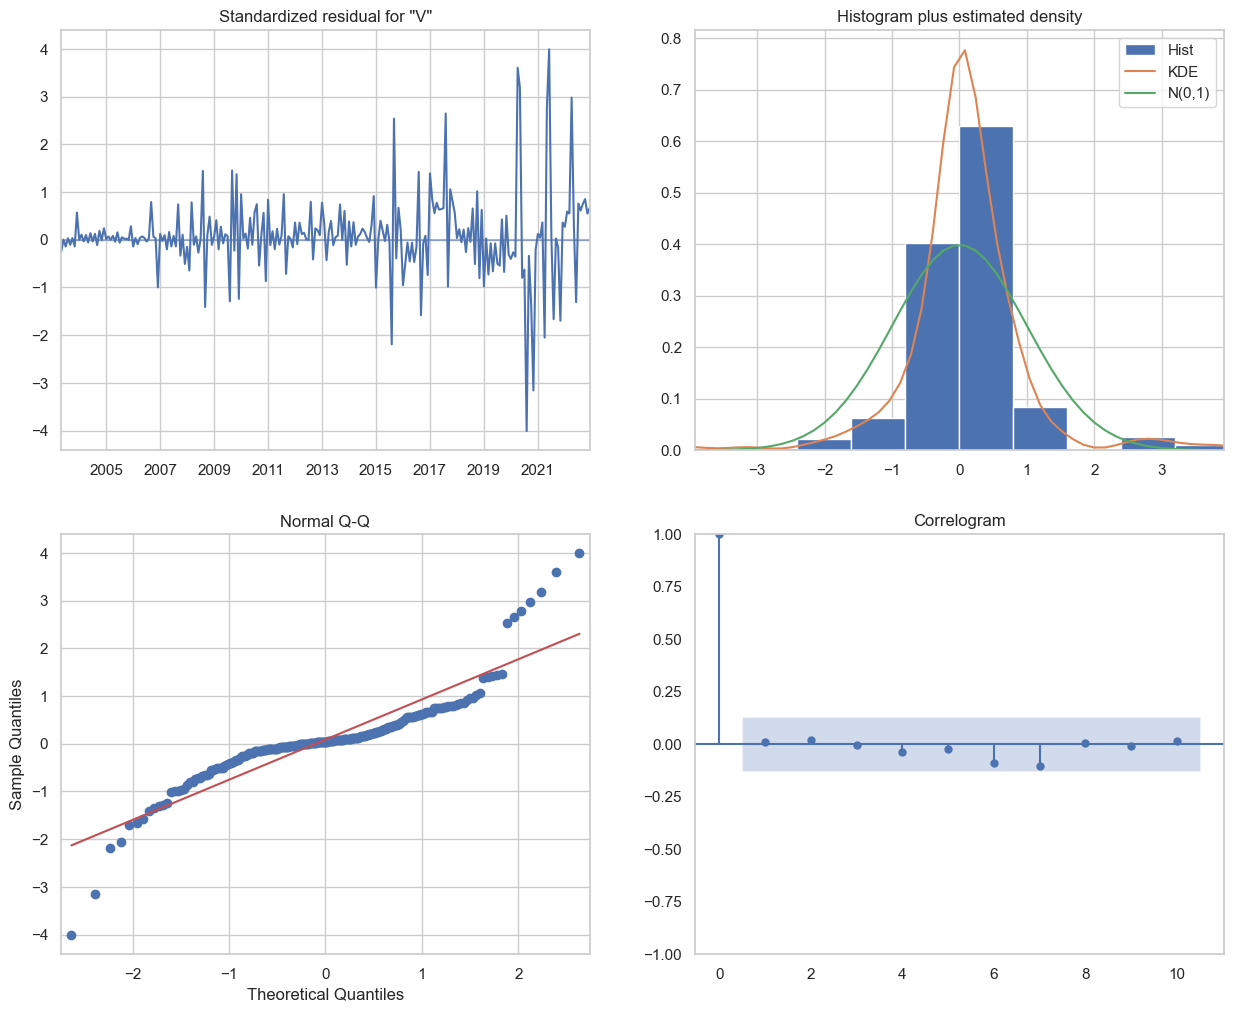

In [ ]:
resultado_modelo.plot_diagnostics(figsize=(15, 12))
plt.grid(False)
plt.show()

In [ ]:
df_sarima['fitted'] = resultado_modelo.fittedvalues

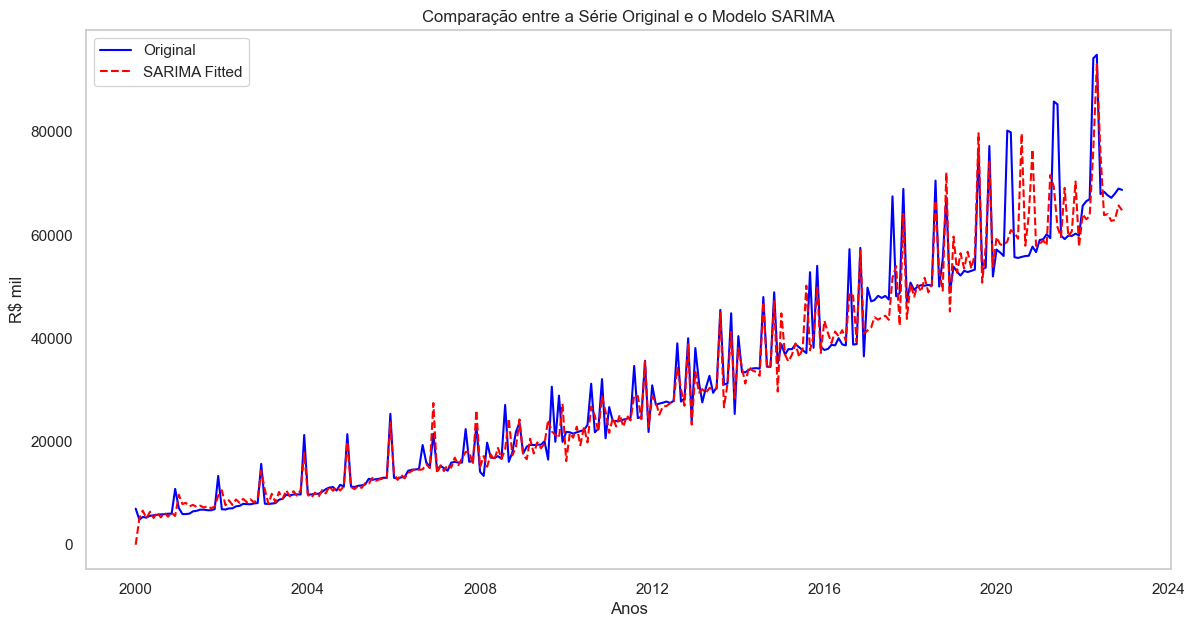

In [ ]:
sns.set_theme(style="whitegrid")

# Plotando a série original e os valores ajustados pelo modelo
plt.figure(figsize=(14, 7))
plt.tight_layout()
sns.lineplot(data=df_sarima, x=df_sarima.index, y='Valor', label='Original', color='blue')
sns.lineplot(data=df_sarima, x=df_sarima.index, y='fitted', label='SARIMA Fitted', color='red', linestyle='--')
plt.title('Comparação entre a Série Original e o Modelo SARIMA')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('Anos')
plt.ylabel('R$ mil')
plt.grid(False) 
plt.legend()
plt.show()

In [ ]:
import plotly.graph_objects as go

# Criando a figura
fig = go.Figure()

# Adicionando a série original
fig.add_trace(go.Scatter(
    x=df_sarima.index,
    y=df_sarima['Valor'],
    mode='lines',
    name='Original',
    line=dict(color='blue')
))

# Adicionando os valores ajustados pelo modelo SARIMA
fig.add_trace(go.Scatter(
    x=df_sarima.index,
    y=df_sarima['fitted'],
    mode='lines',
    name='SARIMA Fitted',
    line=dict(color='red', dash='dash')
))

# Configurando o layout
fig.update_layout(
    title='Comparação entre a Série Original e o Modelo SARIMA',
    xaxis_title='Anos',
    yaxis_title='R$ mil',
    yaxis=dict(tickformat=',d'),  # Formata os valores inteiros no eixo Y
    template='plotly_white',
    hovermode='x',
)

# Exibir gráfico interativo
fig.show()

In [ ]:
import plotly.io as pio

pio.renderers.default = 'browser'  # Faz com que o gráfico abra no navegador
fig.show()

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

# Configurando para exibir no VS Code e no navegador
pio.renderers.default = "vscode"  # Para exibição no VS Code
# pio.renderers.default = "browser"  # Se quiser apenas no navegador

# Calculando a diferença entre a série real e o modelo ajustado
df_sarima['erro'] = df_sarima['Valor'] - df_sarima['fitted']

# Criando a figura
fig = go.Figure()

# Adicionando a linha fixa no Y = 0
fig.add_trace(go.Scatter(
    x=df_sarima.index,
    y=[0] * len(df_sarima),  # Linha fixa no zero
    mode='lines',
    name='Linha Base (Y=0)',
    line=dict(color='black', dash='dash')
))

# Adicionando a série de erros (diferença entre real e ajustado)
fig.add_trace(go.Scatter(
    x=df_sarima.index,
    y=df_sarima['erro'],
    mode='lines',
    name='Erro (Real - Modelo)',
    line=dict(color='red')
))

# Configurando o layout
fig.update_layout(
    title='Erro entre a Série Real e o Modelo SARIMA',
    xaxis_title='Anos',
    yaxis_title='Erro (R$ mil)',
    template='plotly_white',
    hovermode='x',
)

# Exibir gráfico no VS Code
fig.show()

# Exibir gráfico no navegador
pio.renderers.default = "browser"
fig.show()

In [ ]:
# Realizando o teste dos erros
teste = teste_erro(df_sarima['Valor'], df_sarima['fitted'])
teste

,Metric,Value
0,MAD,2.724579e+03
1,MAPE,9.349141e-02
2,MSD,2.226339e+07
3,MPE,-4.667884e-01


In [ ]:
# Teste para anos antes de 2020
teste_antes = teste_erro(df_sarima.loc[df_sarima.index < '2020-01-01', 'Valor'], df_sarima.loc[df_sarima.index < '2020-01-01', 'fitted'])
teste_antes

,Metric,Value
0,MAD,2.096983e+03
1,MAPE,9.228134e-02
2,MSD,1.072502e+07
3,MPE,-4.902188e-01


In [ ]:
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_arch

residuos = resultado_modelo.resid

# Teste de Shapiro-Wilk
shapiro_test = shapiro(residuos)

# Teste de Heterocedasticidade ARCH
arch_test = het_arch(residuos)

# Resultados
test_results = {
    "Shapiro-Wilk": {"Statistic": shapiro_test.statistic, "p-value": shapiro_test.pvalue},
    "ARCH Test": {"LM Statistic": arch_test[0], "p-value": arch_test[1]}
}

test_results


{'Shapiro-Wilk': {'Statistic': np.float64(0.8227736005817),
  'p-value': np.float64(4.5170539634730984e-17)},
 'ARCH Test': {'LM Statistic': np.float64(53.09171503456837),
  'p-value': np.float64(7.15956781068841e-08)}}

/var/folders/wk/k6089y_d7hv_rwb2m8vbm9cr0000gn/T/ipykernel_65863/3000406950.py:4: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



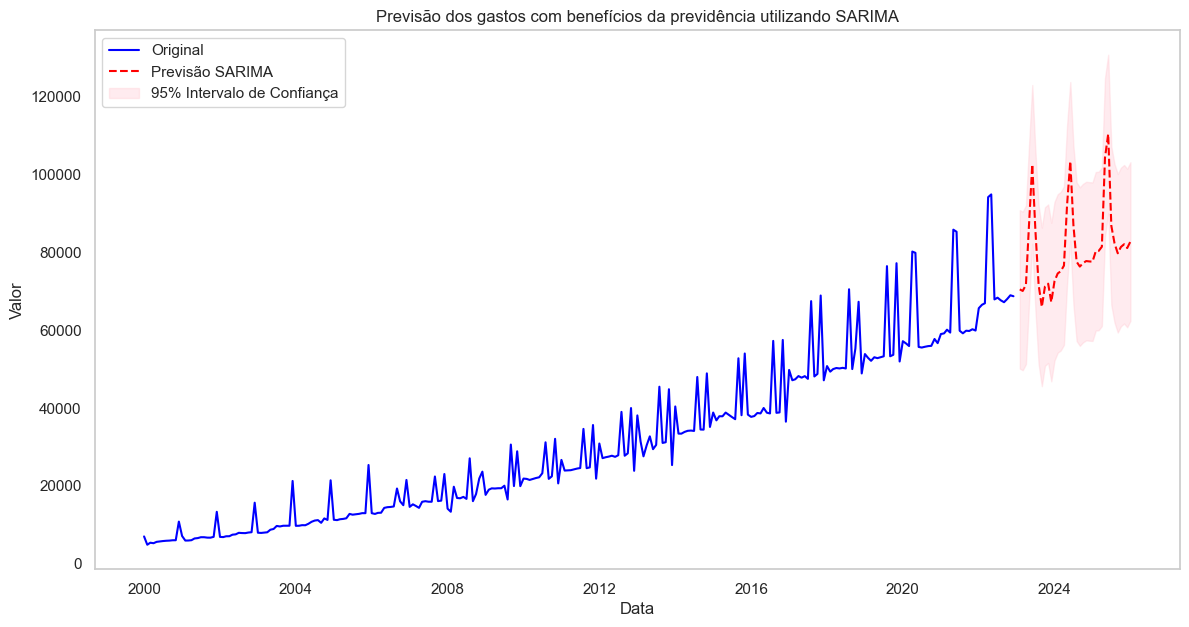

In [ ]:
# Criando as previsões
forecast_periods = 36
forecast = resultado_modelo.forecast(steps=forecast_periods)
forecast_index = pd.date_range(start=df_sarima.index[-1], periods=forecast_periods+1, freq='M')[1:]
forecast_values = forecast.values

# Fazendo intervalo de confiança
ci = 1.96 * np.std(forecast_values)
lower_bound = forecast_values - ci
upper_bound = forecast_values + ci

# Fazendo os gráficos
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_sarima, x=df_sarima.index, y='Valor', label='Original', color='blue')
sns.lineplot(x=forecast_index, y=forecast_values, label='Previsão SARIMA', color='red', linestyle='--')
plt.fill_between(forecast_index, lower_bound, upper_bound, color='pink', alpha=0.3, label='95% Intervalo de Confiança')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.title('Previsão dos gastos com benefícios da previdência utilizando SARIMA')
plt.grid(False)
plt.legend()
plt.show()

In [ ]:
# Criando a figura interativa
fig = go.Figure()

# Configurar o Plotly para exibir no VS Code primeiro
pio.renderers.default = "vscode"

# Linha da série original
fig.add_trace(go.Scatter(
    x=df_sarima.index,
    y=df_sarima['Valor'],
    mode='lines',
    name='Original',
    line=dict(color='blue')
))

# Linha da previsão SARIMA
fig.add_trace(go.Scatter(
    x=forecast_index,
    y=forecast_values,
    mode='lines',
    name='Previsão SARIMA',
    line=dict(color='red', dash='dash')
))

# Área do intervalo de confiança
fig.add_trace(go.Scatter(
    x=list(forecast_index) + list(forecast_index[::-1]),
    y=list(upper_bound) + list(lower_bound[::-1]),
    fill='toself',
    fillcolor='rgba(255, 182, 193, 0.3)',  # Cor rosa com transparência
    line=dict(color='rgba(255,255,255,0)'),
    name='95% Intervalo de Confiança'
))

# Configurações do layout
fig.update_layout(
    title='Previsão dos gastos com benefícios da previdência utilizando SARIMA',
    xaxis_title='Anos',
    yaxis_title='R$ mil',
    template='plotly_white',
    hovermode='x',
)

# Exibir gráfico no VS Code
fig.show()


In [ ]:
# Exibir gráfico no navegador
pio.renderers.default = "browser"
fig.show()

# 6 - Testes